<a href="https://colab.research.google.com/github/dgambone3/CSC6850_Machine_Learning_Project/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [162]:
import pandas as pd
import sklearn 
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import ConfusionMatrixDisplay


# processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate


# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import ComplementNB, MultinomialNB 
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier

In [163]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_Project/Diabetes Indicators Dataset/diabetes_012_health_indicators_BRFSS2015.csv')

In [164]:
X = df.iloc[:, 1:] # features
X = X.astype(int)
y = df.iloc[:, :1]
y = y.astype(int).values.ravel()

# Helper Functions


*   Learning Curves
*   Best Polynomial



### Helper function to get learning curve plot
#### Predicts target variable at every n interval of the dataset to use as points on learning curve plot.

In [165]:
def get_learning_curve(model, X, y, title):
  scores=[]
  perc=[]
  for n in range(1,101):
    perc.append(n)
    XX = X.iloc[0:int(len(X) * (n/100))] #df
    yy = y[0:int(len(y) * (n/100))] #list
    pred = model.predict(XX)
    score = MSE(y_true=yy, y_pred=pred)
    scores.append(score)
  return pd.DataFrame({'percent':perc, 'scores':scores})

### Helper function to find best polynomial for linear regression

In [166]:
def best_poly(X_train, y_train, X_test, y_test):
  degree = [1, 2]
  z = []
  poly_df = pd.DataFrame(columns=['polynomial', 'score'])
  print('   Polynomial Scores')
  for deg in degree:
    linreg = LinearRegression()
    polynomial_features = PolynomialFeatures(degree=deg,
                                             include_bias=False)
    lin_pipe = Pipeline([('scaler', MinMaxScaler()),
                        ("polynomial_features", polynomial_features),
                        ("linear_regression", linreg)])
    lin_pipe.fit(X,y)
    score = lin_pipe.score(X_test,y_test)
    z.append(score)
    print(f'Degree: {deg}  Score: {score}')
  p = z.index(max(z)) + 1
    
  return p 

### Split original data into three seperate ratios
#### Splitting data outside of loop for cohesion. This way assures the same data points are used for all the splits on all the models. 
#### Initialize dataframe labels and plot colors



In [167]:
#### SPLIT FOR FASTER TESTING -  REMOVE FOR FINAL TESTS ####
X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X, 
                                                                        y, 
                                                                        train_size=0.20)
# Create all three splits outside of loop to run each model on same data splits
X55_train, X55_test, y55_train, y55_test = train_test_split(X_train_temp, 
                                                            y_train_temp, 
                                                            train_size=.5, 
                                                            test_size=.5, 
                                                            shuffle=True,
                                                            random_state=1234)
X73_train, X73_test, y73_train, y73_test = train_test_split(X_train_temp, 
                                                            y_train_temp, 
                                                            train_size=.7, 
                                                            test_size=.3, 
                                                            shuffle=True,
                                                            random_state=1234)
X82_train, X82_test, y82_train, y82_test = train_test_split(X_train_temp, 
                                                            y_train_temp, 
                                                            train_size=.8, 
                                                            test_size=.2, 
                                                            shuffle=True,
                                                            random_state=1234)
# List of train and test motels to access later in loop
train = [(X55_train, y55_train), 
         (X73_train, y73_train), 
         (X82_train, y82_train)]
test = [(X55_test, y55_test),
        (X73_test, y73_test),
        (X82_test, y82_test)]

# initialize lists of color for plots
train_colors = ['navy', 'green', 'firebrick']
test_colors = ['skyblue', 'palegreen', 'salmon']

#### Initialize models

In [168]:
titles = ['Decision Tree Classifier',
          'Perceptron',
          'Compliment Naive Bayes',
          'Multinomial Naive Bayes',
          'Logistic Regression',
          'Linear Regression',
          'SVM - Linear',
          'SVM - RBF',
          'Gradient Boost',
          'Muti-Layer Perceptron',
          'Regularilized Linear Regression',
          'Lasso Linear Regression',
          'k-Nearest Neighbors',
          'Linear Regression with Optimal Polynomial']

models = [DecisionTreeClassifier(criterion='entropy', splitter='best'),
          Perceptron(class_weight='balanced'),
          ComplementNB(),
          MultinomialNB (),
          LogisticRegression(class_weight='balanced'), 
          LinearRegression(),
          LinearSVC(class_weight='balanced', dual=False),
          SVC(kernel='rbf', decision_function_shape='ovr'),
          GradientBoostingClassifier(),
          MLPClassifier(max_iter=500, hidden_layer_sizes=10),
          SGDRegressor(loss='squared_error', penalty='l2'),
          Lasso(selection='random'),
          KNeighborsClassifier(weights='distance'),
          LinearRegression()]

# list of split ratios to output onto plots
splits = [(0.5, 0.5), 
          (0.7, 0.3),
          (0.8, 0.2)]

# create labels for fold metrics dataframe
index = []
for i in range(1,11):
  index.append(f'Fold {i}')

### Pipeline

This cell holds a nested loop which performs multiple steps to initiialize the models, get their model metrics, output learning curves, etc. Outputs for metrics of each fold, and split are generated.


1. for each model
*   scale the data
2. for each split on the model
*   fit the pipeline

*   10-fold cross-validation

*   calculate metrics for model performance on test data

*   generate and output learning curves wiht one plot for each model, and all splits on that one plot. 













,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.762712,0.779191,0.762712,0.770714,-0.639927,0.810800
Fold 2,0.758770,0.770480,0.758770,0.764441,-0.717260,0.849034
Fold 3,0.757588,0.772060,0.757588,0.764666,-0.682422,0.833662
Fold 4,0.777296,0.779709,0.777296,0.778497,-0.578215,0.782026
Fold 5,0.763106,0.775657,0.763106,0.769133,-0.683217,0.834056
Fold 6,0.763106,0.776811,0.763106,0.769602,-0.692763,0.838786
Fold 7,0.767048,0.779843,0.767048,0.773147,-0.663331,0.824202
Fold 8,0.779267,0.784601,0.779267,0.781887,-0.559919,0.772960
Fold 9,0.763013,0.775484,0.763013,0.768988,-0.691032,0.837934
Fold 10,0.781940,0.786532,0.781940,0.784221,-0.526829,0.755126


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.758164,0.772289,0.758164,0.764972,-0.703130,0.844876
Fold 2,0.760417,0.773328,0.760417,0.766717,-0.666241,0.826577
Fold 3,0.764921,0.776574,0.764921,0.770592,-0.648648,0.817849
Fold 4,0.765766,0.776054,0.765766,0.770807,-0.631623,0.809403
Fold 5,0.759009,0.774158,0.759009,0.766271,-0.703840,0.846565
Fold 6,0.773585,0.784111,0.773585,0.778724,-0.577917,0.784005
Fold 7,0.770769,0.781100,0.770769,0.775783,-0.604465,0.796114
Fold 8,0.760068,0.775632,0.760068,0.767558,-0.677112,0.832160
Fold 9,0.772177,0.785666,0.772177,0.778567,-0.601628,0.794706
Fold 10,0.756970,0.778247,0.756970,0.767057,-0.688463,0.837792


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.757329,0.769876,0.757329,0.763420,-0.708240,0.849470
Fold 2,0.756837,0.765880,0.756837,0.761293,-0.706258,0.848485
Fold 3,0.758808,0.768653,0.758808,0.763607,-0.708240,0.849470
Fold 4,0.764967,0.779605,0.764967,0.771926,-0.654238,0.822616
Fold 5,0.762749,0.775707,0.762749,0.769031,-0.660183,0.825573
Fold 6,0.769894,0.777323,0.769894,0.773526,-0.632439,0.811776
Fold 7,0.759054,0.770260,0.759054,0.764535,-0.684474,0.836659
Fold 8,0.759547,0.772252,0.759547,0.765718,-0.683482,0.836167
Fold 9,0.770577,0.780798,0.770577,0.775608,-0.583464,0.787580
Fold 10,0.766387,0.779167,0.766387,0.772638,-0.612695,0.802119


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.834844,0.804289,0.834844,0.778470,-0.154407,0.570753
Fold 2,0.810012,0.800806,0.810012,0.770472,-0.135273,0.561293
Fold 3,0.831691,0.799658,0.831691,0.793358,-0.151047,0.570359
Fold 4,0.534095,0.836622,0.534095,0.640629,-0.240935,0.614899
Fold 5,0.823019,0.793546,0.823019,0.785124,-0.173320,0.581395
Fold 6,0.813165,0.777361,0.813165,0.774579,-0.131160,0.560505
Fold 7,0.504927,0.838520,0.504927,0.605694,-1.583691,1.280252
Fold 8,0.683090,0.836380,0.683090,0.744644,-0.116842,0.553410
Fold 9,0.606467,0.828505,0.606467,0.692500,-0.749124,0.866719
Fold 10,0.571767,0.831179,0.571767,0.666052,-0.181599,0.584385


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.829392,0.785949,0.829392,0.779910,-0.159445,0.575169
Fold 2,0.264358,0.859421,0.264358,0.382474,-0.578276,0.782939
Fold 3,0.831926,0.805003,0.831926,0.816743,-0.220738,0.605574
Fold 4,0.740991,0.814489,0.740991,0.765236,-0.931841,0.958333
Fold 5,0.836993,0.791221,0.836993,0.802651,-0.189912,0.591216
Fold 6,0.766826,0.812233,0.766826,0.786253,-0.210643,0.601521
Fold 7,0.839200,0.802227,0.839200,0.814896,-0.166884,0.578992
Fold 8,0.808505,0.812879,0.808505,0.810624,-0.291745,0.640946
Fold 9,0.779780,0.807401,0.779780,0.792276,-0.291745,0.640946
Fold 10,0.720079,0.825614,0.720079,0.766113,-0.536359,0.762320


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.673565,0.826717,0.673565,0.715103,-1.492008,1.239221
Fold 2,0.725055,0.814895,0.725055,0.757015,-0.948523,0.968958
Fold 3,0.756590,0.812565,0.756590,0.777491,-0.776609,0.883469
Fold 4,0.827544,0.792596,0.827544,0.792144,-0.152368,0.573048
Fold 5,0.697955,0.829491,0.697955,0.740889,-1.075848,1.032274
Fold 6,0.090909,0.822851,0.090909,0.135063,-0.837051,0.913525
Fold 7,0.160138,0.823851,0.160138,0.243900,-0.702827,0.845775
Fold 8,0.807834,0.798856,0.807834,0.803197,-0.403232,0.696970
Fold 9,0.719566,0.804128,0.719566,0.756771,-0.296597,0.644899
Fold 10,0.547314,0.851954,0.547314,0.646902,-0.198498,0.596106


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.720536,0.810951,0.720536,0.749297,-1.153351,1.064643
Fold 2,0.721324,0.809673,0.721324,0.749333,-1.146973,1.061490
Fold 3,0.722507,0.810571,0.722507,0.750410,-1.132659,1.056760
Fold 4,0.728814,0.807899,0.728814,0.754596,-1.081749,1.031533
Fold 5,0.735909,0.814961,0.735909,0.761132,-1.024475,1.003153
Fold 6,0.741821,0.823134,0.741821,0.766631,-0.976746,0.979503
Fold 7,0.714229,0.804295,0.714229,0.743784,-1.199478,1.089870
Fold 8,0.724084,0.804868,0.724084,0.750650,-1.119931,1.050453
Fold 9,0.735804,0.811894,0.735804,0.760366,-1.027646,1.004732
Fold 10,0.725158,0.814177,0.725158,0.752524,-1.115237,1.046136


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.716779,0.803469,0.716779,0.744662,-1.174740,1.078829
Fold 2,0.724381,0.806156,0.724381,0.750798,-1.113448,1.048423
Fold 3,0.729448,0.809057,0.729448,0.754739,-1.072586,1.028153
Fold 4,0.725225,0.813081,0.725225,0.752737,-1.106638,1.045045
Fold 5,0.723255,0.811884,0.723255,0.751002,-1.119176,1.052928
Fold 6,0.733033,0.810949,0.733033,0.758226,-1.042110,1.014644
Fold 7,0.736412,0.819830,0.736412,0.761954,-1.015939,1.000282
Fold 8,0.720079,0.807327,0.720079,0.748409,-1.147611,1.065615
Fold 9,0.722613,0.804428,0.722613,0.749403,-1.127179,1.055477
Fold 10,0.732188,0.814340,0.732188,0.757567,-1.049992,1.017178


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.713723,0.799891,0.713723,0.741893,-1.194255,1.091155
Fold 2,0.714954,0.803859,0.714954,0.743280,-1.184347,1.086228
Fold 3,0.722345,0.805006,0.722345,0.749182,-1.124895,1.056664
Fold 4,0.729736,0.809083,0.729736,0.754879,-1.065444,1.027100
Fold 5,0.722099,0.812478,0.722099,0.750229,-1.126877,1.057650
Fold 6,0.726041,0.810292,0.726041,0.752731,-1.095170,1.041882
Fold 7,0.730229,0.810910,0.730229,0.756089,-1.062439,1.024390
Fold 8,0.728997,0.814960,0.728997,0.755864,-1.072359,1.029318
Fold 9,0.722031,0.803327,0.722031,0.748747,-1.126974,1.057910
Fold 10,0.729670,0.815036,0.729670,0.755810,-1.065538,1.027353


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.834056,0.785787,0.834056,0.801211,-0.234928,0.610564
Fold 2,0.831691,0.784508,0.831691,0.800418,-0.254062,0.620024
Fold 3,0.835633,0.787943,0.835633,0.802343,-0.219458,0.604257
Fold 4,0.834844,0.787834,0.834844,0.803133,-0.225821,0.607410
Fold 5,0.841151,0.792736,0.841151,0.804273,-0.174911,0.582184
Fold 6,0.837998,0.793713,0.837998,0.807614,-0.200366,0.594797
Fold 7,0.832873,0.782186,0.832873,0.798681,-0.241731,0.615294
Fold 8,0.828932,0.775689,0.828932,0.793274,-0.273550,0.631060
Fold 9,0.841088,0.794612,0.841088,0.807207,-0.177754,0.583596
Fold 10,0.833596,0.785877,0.833596,0.800932,-0.238207,0.612382


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.829110,0.778755,0.829110,0.795673,-0.268977,0.629505
Fold 2,0.835304,0.787285,0.835304,0.801978,-0.219035,0.604730
Fold 3,0.837556,0.789196,0.837556,0.802854,-0.200874,0.595721
Fold 4,0.834178,0.786071,0.834178,0.801114,-0.228115,0.609234
Fold 5,0.833896,0.785838,0.833896,0.800604,-0.228442,0.610360
Fold 6,0.834131,0.784733,0.834131,0.799913,-0.228213,0.610251
Fold 7,0.840890,0.795755,0.840890,0.808369,-0.173694,0.582371
Fold 8,0.833568,0.783170,0.833568,0.798696,-0.232720,0.611659
Fold 9,0.831597,0.779164,0.831597,0.795766,-0.248611,0.619544
Fold 10,0.837792,0.791097,0.837792,0.804369,-0.198667,0.594762


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.830500,0.780836,0.830500,0.797475,-0.254922,0.624045
Fold 2,0.827544,0.776418,0.827544,0.793733,-0.278702,0.635871
Fold 3,0.835427,0.787914,0.835427,0.802403,-0.215288,0.604336
Fold 4,0.836659,0.787564,0.836659,0.801208,-0.205379,0.599409
Fold 5,0.832225,0.784460,0.832225,0.800015,-0.241050,0.617147
Fold 6,0.832225,0.781637,0.832225,0.797337,-0.241050,0.617147
Fold 7,0.840847,0.794169,0.840847,0.806138,-0.171592,0.581917
Fold 8,0.834196,0.785919,0.834196,0.801119,-0.225162,0.608524
Fold 9,0.831198,0.779176,0.831198,0.795476,-0.249034,0.621242
Fold 10,0.836865,0.789295,0.836865,0.802899,-0.203452,0.598571


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.643674,0.853066,0.643674,0.719369,-0.746758,0.863618
Fold 2,0.639338,0.839214,0.639338,0.712546,-0.808145,0.893969
Fold 3,0.651557,0.845063,0.651557,0.722101,-0.772310,0.878203
Fold 4,0.662988,0.847224,0.662988,0.731990,-0.682422,0.833662
Fold 5,0.641703,0.850062,0.641703,0.716567,-0.761174,0.872684
Fold 6,0.648404,0.858864,0.648404,0.724713,-0.659353,0.822231
Fold 7,0.641309,0.848121,0.641309,0.717203,-0.771515,0.877808
Fold 8,0.644856,0.849653,0.644856,0.719651,-0.740491,0.862436
Fold 9,0.645899,0.847764,0.645899,0.719356,-0.772201,0.878155
Fold 10,0.659700,0.855263,0.659700,0.729893,-0.685492,0.833596


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.641610,0.844247,0.641610,0.715319,-0.767828,0.876971
Fold 2,0.646959,0.846447,0.646959,0.721174,-0.709373,0.847973
Fold 3,0.646959,0.844475,0.646959,0.718210,-0.772368,0.879223
Fold 4,0.638232,0.848783,0.638232,0.714881,-0.723561,0.855011
Fold 5,0.644426,0.845746,0.644426,0.716591,-0.803566,0.896115
Fold 6,0.649395,0.848371,0.649395,0.723394,-0.688439,0.838919
Fold 7,0.641509,0.857071,0.641509,0.717043,-0.718543,0.852718
Fold 8,0.637567,0.850254,0.637567,0.714406,-0.765650,0.876091
Fold 9,0.635314,0.846929,0.635314,0.711778,-0.773595,0.880034
Fold 10,0.651647,0.855624,0.651647,0.724668,-0.689598,0.838355


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.635871,0.842531,0.635871,0.710478,-0.797912,0.894063
Fold 2,0.628973,0.840519,0.628973,0.705817,-0.798408,0.894309
Fold 3,0.647204,0.846205,0.647204,0.720921,-0.720130,0.855383
Fold 4,0.644494,0.845963,0.644494,0.717722,-0.741929,0.866223
Fold 5,0.640059,0.848282,0.640059,0.715244,-0.744901,0.867701
Fold 6,0.646957,0.846827,0.646957,0.720094,-0.741433,0.865977
Fold 7,0.639813,0.846127,0.639813,0.714739,-0.744492,0.866470
Fold 8,0.642276,0.855747,0.642276,0.718746,-0.723163,0.855876
Fold 9,0.635535,0.845190,0.635535,0.711880,-0.779167,0.884919
Fold 10,0.650567,0.853791,0.650567,0.722916,-0.702868,0.846969


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,nan,nan,nan,nan,0.187040,0.414685
Fold 2,nan,nan,nan,nan,0.148335,0.414492
Fold 3,nan,nan,nan,nan,0.178523,0.404595
Fold 4,nan,nan,nan,nan,0.170024,0.427115
Fold 5,nan,nan,nan,nan,0.178522,0.388638
Fold 6,nan,nan,nan,nan,0.181499,0.377035
Fold 7,nan,nan,nan,nan,0.180797,0.427187
Fold 8,nan,nan,nan,nan,0.176489,0.416787
Fold 9,nan,nan,nan,nan,0.170781,0.392608
Fold 10,nan,nan,nan,nan,0.194607,0.411833


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,nan,nan,nan,nan,0.164183,0.424497
Fold 2,nan,nan,nan,nan,0.155112,0.392272
Fold 3,nan,nan,nan,nan,0.183634,0.430896
Fold 4,nan,nan,nan,nan,0.180309,0.412413
Fold 5,nan,nan,nan,nan,0.168306,0.403293
Fold 6,nan,nan,nan,nan,0.171950,0.405930
Fold 7,nan,nan,nan,nan,0.176259,0.387866
Fold 8,nan,nan,nan,nan,0.189731,0.416251
Fold 9,nan,nan,nan,nan,0.168142,0.419506
Fold 10,nan,nan,nan,nan,0.191303,0.399357


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,nan,nan,nan,nan,0.162928,0.420347
Fold 2,nan,nan,nan,nan,0.155205,0.434877
Fold 3,nan,nan,nan,nan,0.159556,0.389048
Fold 4,nan,nan,nan,nan,0.186345,0.425942
Fold 5,nan,nan,nan,nan,0.167209,0.412494
Fold 6,nan,nan,nan,nan,0.177339,0.407477
Fold 7,nan,nan,nan,nan,0.177409,0.404446
Fold 8,nan,nan,nan,nan,0.178619,0.400126
Fold 9,nan,nan,nan,nan,0.173918,0.415205
Fold 10,nan,nan,nan,nan,0.191300,0.400488


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.817107,0.813234,0.817107,0.814830,-0.362487,0.673630
Fold 2,0.812377,0.809479,0.812377,0.810483,-0.407930,0.696098
Fold 3,0.816713,0.814969,0.816713,0.815324,-0.362642,0.675207
Fold 4,0.824202,0.817062,0.824202,0.820417,-0.306959,0.647615
Fold 5,0.816318,0.813988,0.816318,0.814646,-0.370597,0.679149
Fold 6,0.820654,0.818602,0.820654,0.819214,-0.321278,0.654710
Fold 7,0.815530,0.813704,0.815530,0.814076,-0.379347,0.683484
Fold 8,0.820654,0.813589,0.820654,0.816979,-0.326051,0.657075
Fold 9,0.822555,0.818676,0.822555,0.820255,-0.320198,0.654180
Fold 10,0.821372,0.819848,0.821372,0.819915,-0.337072,0.661278


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.812218,0.808996,0.812218,0.810210,-0.398372,0.693694
Fold 2,0.807714,0.804402,0.807714,0.805661,-0.439801,0.714245
Fold 3,0.824606,0.818959,0.824606,0.821482,-0.296785,0.643300
Fold 4,0.818975,0.811736,0.818975,0.815150,-0.345592,0.667511
Fold 5,0.813908,0.813416,0.813908,0.812974,-0.385964,0.688626
Fold 6,0.822585,0.815687,0.822585,0.818912,-0.316064,0.653900
Fold 7,0.816671,0.816126,0.816671,0.815692,-0.363824,0.676711
Fold 8,0.820614,0.816475,0.820614,0.818132,-0.333744,0.661785
Fold 9,0.818643,0.813031,0.818643,0.815522,-0.351338,0.670515
Fold 10,0.822304,0.819900,0.822304,0.820516,-0.318420,0.654182


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.811530,0.806605,0.811530,0.808757,-0.404541,0.698448
Fold 2,0.812762,0.811956,0.812762,0.811291,-0.387201,0.689825
Fold 3,0.808820,0.803759,0.808820,0.805995,-0.427827,0.710027
Fold 4,0.824587,0.818250,0.824587,0.821235,-0.284648,0.638827
Fold 5,0.813501,0.809827,0.813501,0.811250,-0.388688,0.690564
Fold 6,0.816704,0.822075,0.816704,0.814792,-0.365898,0.679231
Fold 7,0.818675,0.814143,0.818675,0.816030,-0.344206,0.667652
Fold 8,0.818921,0.816468,0.818921,0.817241,-0.334782,0.662971
Fold 9,0.820601,0.812989,0.820601,0.816582,-0.332765,0.662888
Fold 10,0.821833,0.819894,0.821833,0.820243,-0.319883,0.656481


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.844698,0.807718,0.844698,0.784216,-0.148826,0.567994
Fold 2,0.842728,0.793393,0.842728,0.784245,-0.164771,0.575877
Fold 3,0.843516,0.797180,0.843516,0.785128,-0.155820,0.572724
Fold 4,0.840363,0.779160,0.840363,0.779121,-0.181275,0.585337
Fold 5,0.838786,0.768584,0.838786,0.775680,-0.194003,0.591644
Fold 6,0.845093,0.800822,0.845093,0.789688,-0.143092,0.566417
Fold 7,0.841939,0.790241,0.841939,0.780529,-0.168547,0.579030
Fold 8,0.843910,0.805322,0.843910,0.781680,-0.152638,0.571147
Fold 9,0.844243,0.801430,0.844243,0.784640,-0.152289,0.570978
Fold 10,0.843849,0.803925,0.843849,0.782421,-0.155288,0.571372


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.836149,0.763832,0.836149,0.775795,-0.212225,0.601351
Fold 2,0.843468,0.797586,0.843468,0.783772,-0.153203,0.572072
Fold 3,0.844876,0.811140,0.844876,0.784439,-0.141852,0.566441
Fold 4,0.841498,0.791608,0.841498,0.780132,-0.169093,0.579955
Fold 5,0.843468,0.802637,0.843468,0.784141,-0.151381,0.572072
Fold 6,0.839763,0.778088,0.839763,0.778927,-0.182871,0.587722
Fold 7,0.842861,0.794849,0.842861,0.782506,-0.157803,0.574486
Fold 8,0.842580,0.794708,0.842580,0.783883,-0.160073,0.575613
Fold 9,0.841453,0.789747,0.841453,0.780609,-0.169154,0.580118
Fold 10,0.842861,0.805319,0.842861,0.778701,-0.157803,0.574486


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.839369,0.778304,0.839369,0.777274,-0.183580,0.588569
Fold 2,0.837891,0.773014,0.837891,0.777502,-0.195470,0.594481
Fold 3,0.842572,0.795553,0.842572,0.781953,-0.157818,0.575758
Fold 4,0.842818,0.804035,0.842818,0.779979,-0.155836,0.574772
Fold 5,0.840847,0.790280,0.840847,0.778354,-0.171690,0.582656
Fold 6,0.841587,0.791823,0.841587,0.781588,-0.165745,0.579699
Fold 7,0.840847,0.784545,0.840847,0.777492,-0.171592,0.581917
Fold 8,0.841340,0.789131,0.841340,0.781519,-0.167624,0.579946
Fold 9,0.841055,0.792473,0.841055,0.778045,-0.169762,0.581814
Fold 10,0.844012,0.817031,0.844012,0.780644,-0.145980,0.569985


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.843122,0.797767,0.843122,0.808652,-0.159190,0.573118
Fold 2,0.840363,0.795232,0.840363,0.807574,-0.181513,0.584155
Fold 3,0.847458,0.806782,0.847458,0.815743,-0.124001,0.556957
Fold 4,0.846275,0.802656,0.846275,0.812946,-0.133547,0.561687
Fold 5,0.853764,0.815777,0.853764,0.821379,-0.073091,0.531730
Fold 6,0.842728,0.799386,0.842728,0.810547,-0.162184,0.575877
Fold 7,0.848640,0.807260,0.848640,0.817097,-0.114455,0.552227
Fold 8,0.846669,0.802083,0.846669,0.808886,-0.130365,0.560110
Fold 9,0.849369,0.810109,0.849369,0.817167,-0.108521,0.549290
Fold 10,0.849763,0.810169,0.849763,0.818006,-0.107450,0.547713


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.847128,0.805270,0.847128,0.814322,-0.123691,0.557432
Fold 2,0.840653,0.793466,0.840653,0.806042,-0.175903,0.583333
Fold 3,0.852196,0.813790,0.852196,0.816312,-0.081127,0.536318
Fold 4,0.846002,0.802386,0.846002,0.810375,-0.132772,0.561937
Fold 5,0.842061,0.798541,0.842061,0.810062,-0.162714,0.577703
Fold 6,0.849620,0.808445,0.849620,0.815846,-0.103522,0.548296
Fold 7,0.847085,0.806213,0.847085,0.815610,-0.123750,0.557589
Fold 8,0.851309,0.811034,0.851309,0.819210,-0.089697,0.540693
Fold 9,0.844551,0.799022,0.844551,0.806864,-0.144182,0.567727
Fold 10,0.854126,0.816748,0.854126,0.822208,-0.066995,0.529428


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.846514,0.803466,0.846514,0.811801,-0.126110,0.559990
Fold 2,0.846514,0.804569,0.846514,0.812376,-0.124624,0.559251
Fold 3,0.840847,0.793058,0.840847,0.804873,-0.171690,0.582656
Fold 4,0.852180,0.813763,0.852180,0.816062,-0.080531,0.537324
Fold 5,0.844297,0.800395,0.844297,0.810011,-0.142459,0.568120
Fold 6,0.848485,0.807215,0.848485,0.814047,-0.110257,0.552106
Fold 7,0.850456,0.810202,0.850456,0.817384,-0.094214,0.543484
Fold 8,0.845282,0.801231,0.845282,0.810706,-0.135879,0.564178
Fold 9,0.846969,0.822415,0.846969,0.811639,-0.123685,0.558896
Fold 10,0.854608,0.817888,0.854608,0.821024,-0.060762,0.527600


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.846275,0.800036,0.846275,0.805625,-0.136070,0.561687
Fold 2,0.841151,0.790936,0.841151,0.799127,-0.177527,0.582184
Fold 3,0.845487,0.801719,0.845487,0.807605,-0.139910,0.564840
Fold 4,0.843122,0.799261,0.843122,0.811686,-0.159002,0.574300
Fold 5,0.849034,0.807220,0.849034,0.806273,-0.111273,0.550650
Fold 6,0.844304,0.800703,0.844304,0.810291,-0.149456,0.569570
Fold 7,0.850217,0.809491,0.850217,0.807197,-0.101728,0.545920
Fold 8,0.847458,0.803108,0.847458,0.805683,-0.124001,0.556957
Fold 9,0.850158,0.809369,0.850158,0.812265,-0.104542,0.547319
Fold 10,0.849369,0.809619,0.849369,0.818853,-0.110639,0.549290


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.842342,0.793393,0.842342,0.799215,-0.162283,0.576577
Fold 2,0.844876,0.799529,0.844876,0.809006,-0.141852,0.566441
Fold 3,0.846002,0.800404,0.846002,0.806340,-0.132772,0.561937
Fold 4,0.849381,0.808537,0.849381,0.812458,-0.105531,0.548423
Fold 5,0.844032,0.803160,0.844032,0.814866,-0.146848,0.569820
Fold 6,0.847930,0.805441,0.847930,0.810702,-0.117124,0.555055
Fold 7,0.847367,0.804847,0.847367,0.813597,-0.121480,0.556463
Fold 8,0.846522,0.802023,0.846522,0.810502,-0.128290,0.559842
Fold 9,0.843988,0.796072,0.843988,0.800143,-0.148722,0.569980
Fold 10,0.851591,0.812195,0.851591,0.819973,-0.087427,0.539566


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.844789,0.798796,0.844789,0.806049,-0.139982,0.566888
Fold 2,0.844543,0.798569,0.844543,0.804443,-0.141964,0.567874
Fold 3,0.840847,0.792469,0.840847,0.804512,-0.171690,0.582656
Fold 4,0.849470,0.808259,0.849470,0.810297,-0.102330,0.548165
Fold 5,0.842079,0.795796,0.842079,0.806234,-0.161781,0.577729
Fold 6,0.844297,0.803265,0.844297,0.815029,-0.143946,0.568859
Fold 7,0.849470,0.807881,0.849470,0.814729,-0.102150,0.547425
Fold 8,0.844543,0.798187,0.844543,0.806707,-0.141831,0.567135
Fold 9,0.847215,0.804988,0.847215,0.812421,-0.120216,0.557171
Fold 10,0.849187,0.808847,0.849187,0.815603,-0.104362,0.549285


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,nan,nan,nan,nan,0.180221,0.418163
Fold 2,nan,nan,nan,nan,0.136393,0.420305
Fold 3,nan,nan,nan,nan,0.174584,0.406535
Fold 4,nan,nan,nan,nan,0.165842,0.429268
Fold 5,nan,nan,nan,nan,0.171027,0.392184
Fold 6,nan,nan,nan,nan,0.173027,0.380937
Fold 7,nan,nan,nan,nan,0.167584,0.434078
Fold 8,nan,nan,nan,nan,0.169547,0.420300
Fold 9,nan,nan,nan,nan,0.168216,0.393822
Fold 10,nan,nan,nan,nan,0.185928,0.416271


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,nan,nan,nan,nan,0.153869,0.429735
Fold 2,nan,nan,nan,nan,0.147983,0.395582
Fold 3,nan,nan,nan,nan,0.181475,0.432036
Fold 4,nan,nan,nan,nan,0.175174,0.414997
Fold 5,nan,nan,nan,nan,0.162286,0.406212
Fold 6,nan,nan,nan,nan,0.167988,0.407873
Fold 7,nan,nan,nan,nan,0.168665,0.391441
Fold 8,nan,nan,nan,nan,0.176533,0.423031
Fold 9,nan,nan,nan,nan,0.166507,0.420330
Fold 10,nan,nan,nan,nan,0.182090,0.403907


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,nan,nan,nan,nan,0.156966,0.423341
Fold 2,nan,nan,nan,nan,0.151322,0.436876
Fold 3,nan,nan,nan,nan,0.153409,0.391894
Fold 4,nan,nan,nan,nan,0.184751,0.426777
Fold 5,nan,nan,nan,nan,0.162434,0.414859
Fold 6,nan,nan,nan,nan,0.175321,0.408476
Fold 7,nan,nan,nan,nan,0.171163,0.407516
Fold 8,nan,nan,nan,nan,0.172775,0.402973
Fold 9,nan,nan,nan,nan,0.168615,0.417871
Fold 10,nan,nan,nan,nan,0.189726,0.401267


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,nan,nan,nan,nan,-0.000131,0.510159
Fold 2,nan,nan,nan,nan,-0.000042,0.486706
Fold 3,nan,nan,nan,nan,-0.000027,0.492535
Fold 4,nan,nan,nan,nan,-0.000557,0.514898
Fold 5,nan,nan,nan,nan,-0.000660,0.473408
Fold 6,nan,nan,nan,nan,-0.001619,0.461386
Fold 7,nan,nan,nan,nan,-0.001058,0.522019
Fold 8,nan,nan,nan,nan,-0.000212,0.506217
Fold 9,nan,nan,nan,nan,-0.000470,0.473690
Fold 10,nan,nan,nan,nan,-0.000165,0.511429


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,nan,nan,nan,nan,-0.000180,0.507973
Fold 2,nan,nan,nan,nan,-0.001330,0.464907
Fold 3,nan,nan,nan,nan,-0.001263,0.528489
Fold 4,nan,nan,nan,nan,-0.000031,0.503148
Fold 5,nan,nan,nan,nan,-0.000175,0.484990
Fold 6,nan,nan,nan,nan,-0.000035,0.490242
Fold 7,nan,nan,nan,nan,-0.000829,0.471249
Fold 8,nan,nan,nan,nan,-0.000436,0.513944
Fold 9,nan,nan,nan,nan,-0.000151,0.504376
Fold 10,nan,nan,nan,nan,-0.000052,0.493853


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,nan,nan,nan,nan,-0.000034,0.502181
Fold 2,nan,nan,nan,nan,-0.000366,0.514960
Fold 3,nan,nan,nan,nan,-0.001457,0.463583
Fold 4,nan,nan,nan,nan,-0.000830,0.523927
Fold 5,nan,nan,nan,nan,-0.000004,0.495317
Fold 6,nan,nan,nan,nan,-0.000004,0.495317
Fold 7,nan,nan,nan,nan,-0.000073,0.491708
Fold 8,nan,nan,nan,nan,-0.000080,0.487178
Fold 9,nan,nan,nan,nan,-0.000089,0.502665
Fold 10,nan,nan,nan,nan,-0.000041,0.495245


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.825778,0.787471,0.825778,0.802707,-0.287546,0.636579
Fold 2,0.810012,0.765360,0.810012,0.784034,-0.415105,0.699645
Fold 3,0.822231,0.778827,0.822231,0.795946,-0.322869,0.655499
Fold 4,0.815136,0.771219,0.815136,0.789122,-0.372984,0.680331
Fold 5,0.824596,0.777576,0.824596,0.794720,-0.299005,0.643674
Fold 6,0.823808,0.787482,0.823808,0.802303,-0.298209,0.643279
Fold 7,0.815136,0.773661,0.815136,0.791100,-0.375370,0.681514
Fold 8,0.823413,0.775135,0.823413,0.793474,-0.313323,0.650769
Fold 9,0.823344,0.783296,0.823344,0.797871,-0.306670,0.647476
Fold 10,0.820978,0.782627,0.820978,0.797772,-0.318734,0.652208


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.815315,0.772884,0.815315,0.790472,-0.373401,0.681306
Fold 2,0.816160,0.777450,0.816160,0.793710,-0.361483,0.675394
Fold 3,0.820946,0.781842,0.820946,0.797592,-0.316081,0.652872
Fold 4,0.819820,0.774628,0.819820,0.792477,-0.335377,0.662444
Fold 5,0.818975,0.778418,0.818975,0.794726,-0.331568,0.661599
Fold 6,0.817798,0.772575,0.817798,0.790078,-0.341003,0.666291
Fold 7,0.817516,0.778142,0.817516,0.794169,-0.341689,0.665728
Fold 8,0.821177,0.778794,0.821177,0.795999,-0.327501,0.658688
Fold 9,0.820614,0.775006,0.820614,0.792693,-0.325230,0.657561
Fold 10,0.821459,0.781674,0.821459,0.797015,-0.303096,0.646578


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,0.818428,0.774999,0.818428,0.792279,-0.338649,0.665681
Fold 2,0.818182,0.775558,0.818182,0.792768,-0.343604,0.668145
Fold 3,0.815225,0.775967,0.815225,0.792445,-0.367384,0.679970
Fold 4,0.819906,0.779610,0.819906,0.795736,-0.323787,0.658290
Fold 5,0.819167,0.774744,0.819167,0.792175,-0.332704,0.662725
Fold 6,0.816457,0.770982,0.816457,0.789209,-0.358962,0.675782
Fold 7,0.818921,0.773593,0.818921,0.791376,-0.333294,0.662232
Fold 8,0.808820,0.764554,0.808820,0.783261,-0.417617,0.704114
Fold 9,0.825037,0.778756,0.825037,0.795804,-0.288175,0.640710
Fold 10,0.818876,0.779095,0.818876,0.795051,-0.327315,0.660177


   Polynomial Scores
Degree: 1  Score: 0.17438977247962872
Degree: 2  Score: 0.20510901856876262


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,nan,nan,nan,nan,0.205244,0.405399
Fold 2,nan,nan,nan,nan,0.163496,0.407114
Fold 3,nan,nan,nan,nan,0.192592,0.397665
Fold 4,nan,nan,nan,nan,0.198586,0.412417
Fold 5,nan,nan,nan,nan,0.210972,0.373286
Fold 6,nan,nan,nan,nan,0.202569,0.367329
Fold 7,nan,nan,nan,nan,0.199199,0.417592
Fold 8,nan,nan,nan,nan,0.198814,0.405488
Fold 9,nan,nan,nan,nan,0.185235,0.385765
Fold 10,nan,nan,nan,nan,0.218104,0.399818


   Polynomial Scores
Degree: 1  Score: 0.1767403521674663
Degree: 2  Score: 0.20809004418785737


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,nan,nan,nan,nan,0.175501,0.418748
Fold 2,nan,nan,nan,nan,0.169649,0.385523
Fold 3,nan,nan,nan,nan,0.216194,0.413710
Fold 4,nan,nan,nan,nan,0.201550,0.401726
Fold 5,nan,nan,nan,nan,0.182963,0.396185
Fold 6,nan,nan,nan,nan,0.211877,0.386358
Fold 7,nan,nan,nan,nan,0.202681,0.375425
Fold 8,nan,nan,nan,nan,0.213861,0.403855
Fold 9,nan,nan,nan,nan,0.187370,0.409809
Fold 10,nan,nan,nan,nan,0.215583,0.387367


   Polynomial Scores
Degree: 1  Score: 0.1863289605986621
Degree: 2  Score: 0.218069165804765


,Accuracy,Precision,Recall,F1-Score,R2,Error
Fold 1,nan,nan,nan,nan,0.188131,0.407691
Fold 2,nan,nan,nan,nan,0.167028,0.428791
Fold 3,nan,nan,nan,nan,0.175206,0.381804
Fold 4,nan,nan,nan,nan,0.216169,0.410330
Fold 5,nan,nan,nan,nan,0.187550,0.402419
Fold 6,nan,nan,nan,nan,0.201172,0.395672
Fold 7,nan,nan,nan,nan,0.217739,0.384616
Fold 8,nan,nan,nan,nan,0.196938,0.391202
Fold 9,nan,nan,nan,nan,0.196426,0.403893
Fold 10,nan,nan,nan,nan,0.217248,0.387637


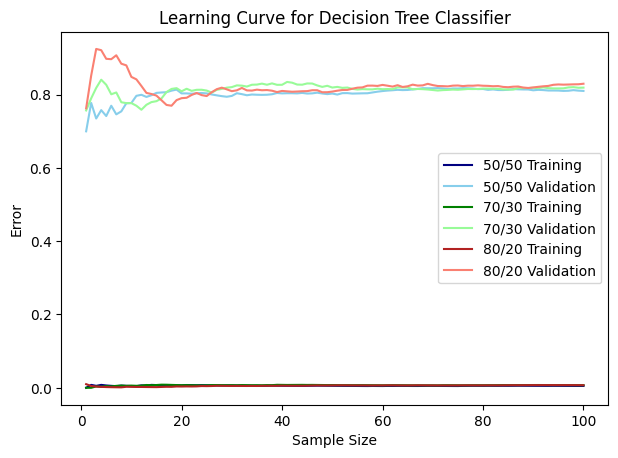

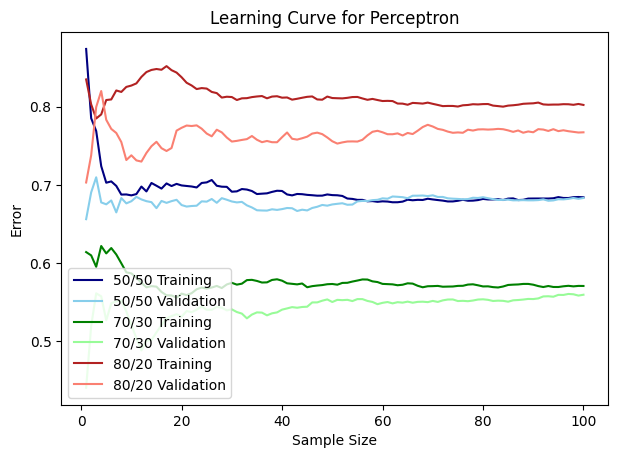

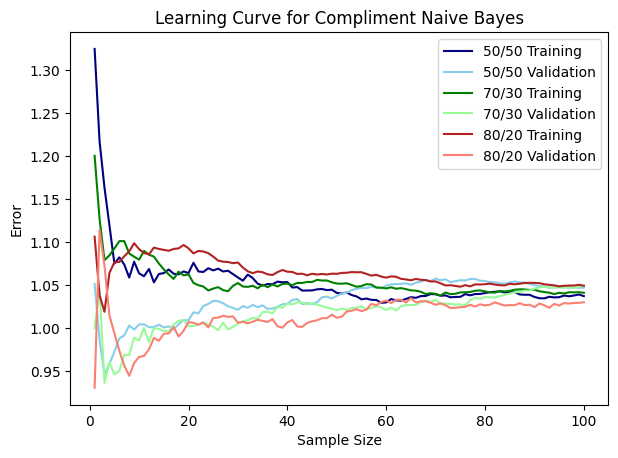

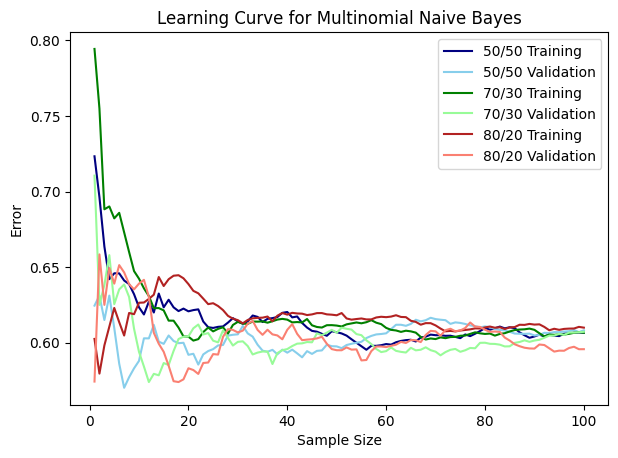

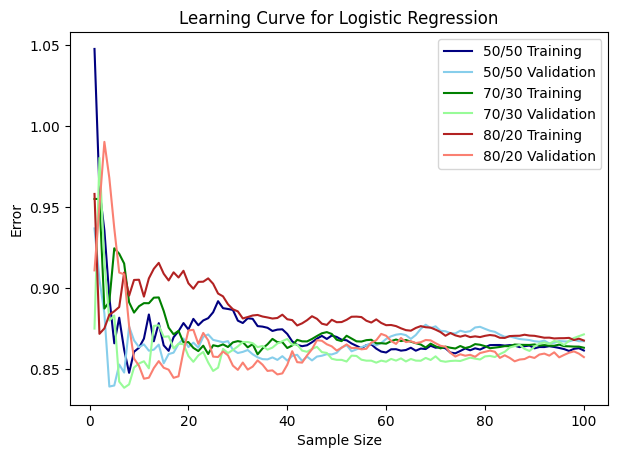

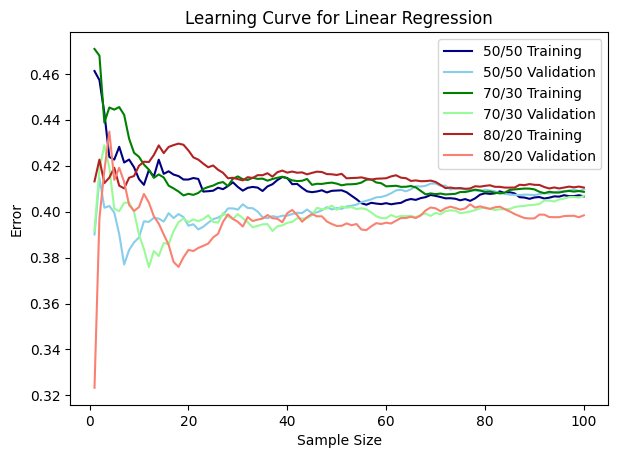

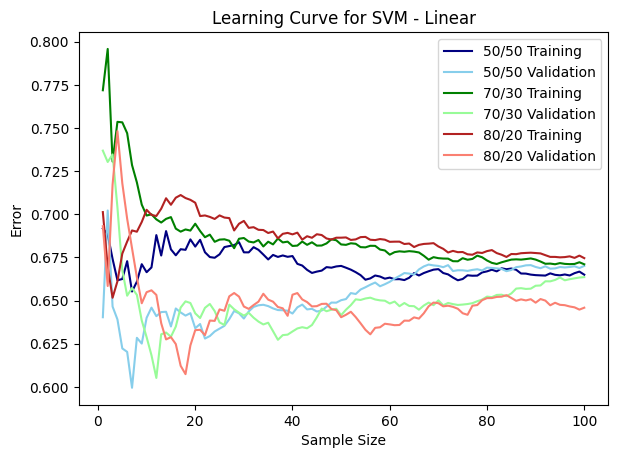

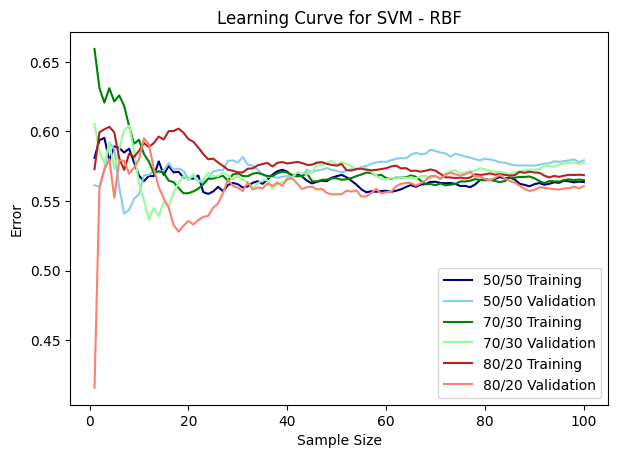

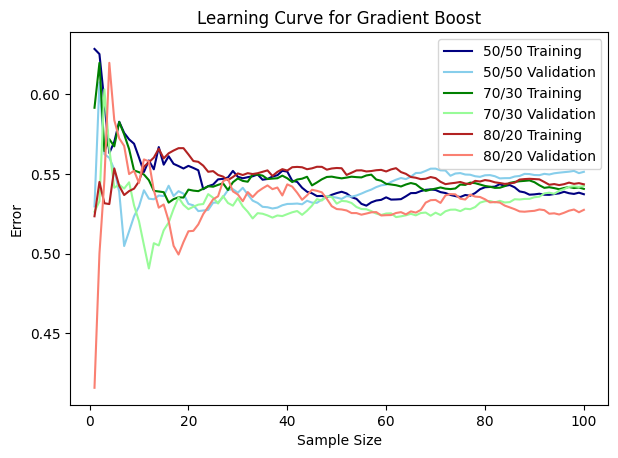

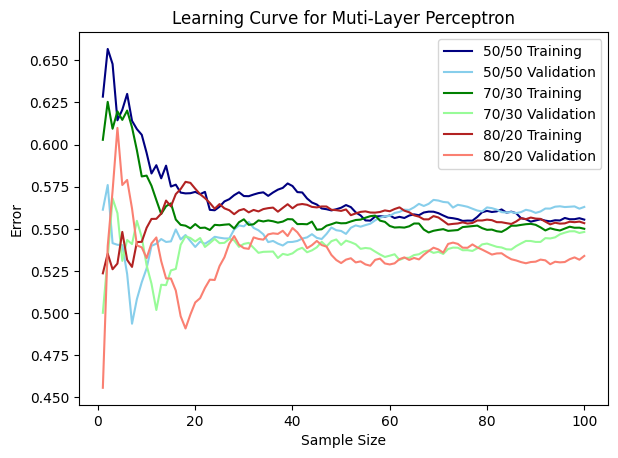

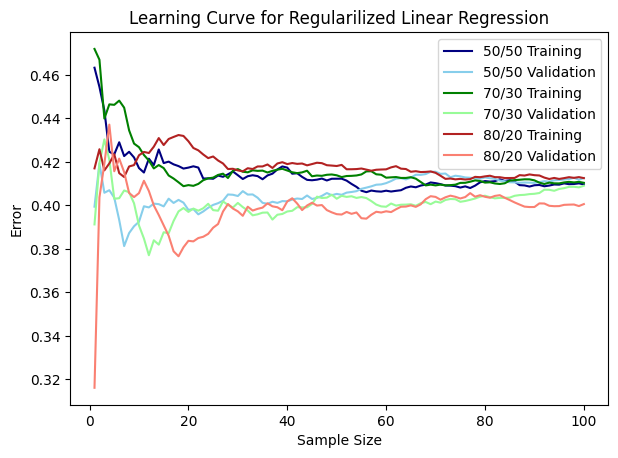

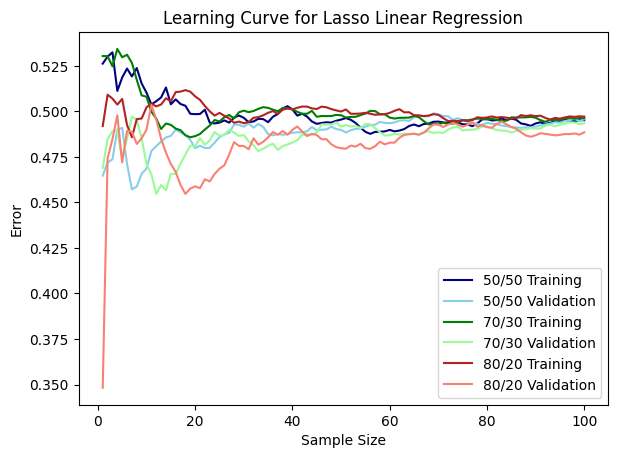

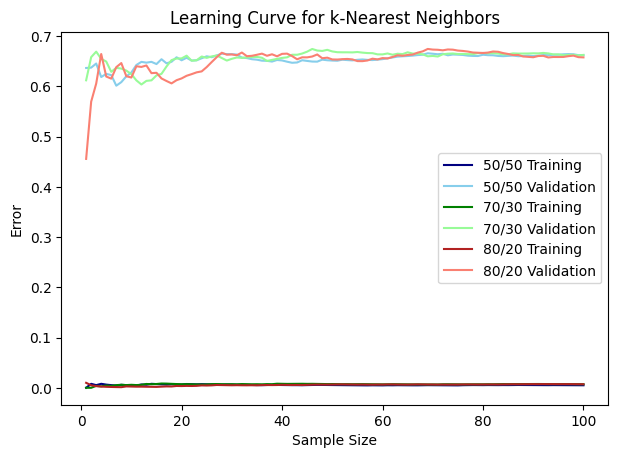

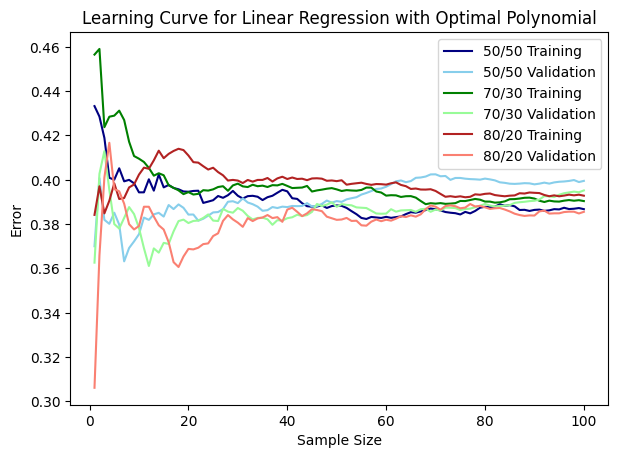

In [169]:
i = 0
# dataframe to store all split information, will be used to pick the best splits
splits_df = pd.DataFrame(columns=['Model', 
                                  'Split', 
                                  'Error',  
                                  'Generalization', 
                                  'true', 
                                  'pred'])
# dataframe to hold all model and split metrics
big_df = pd.DataFrame(columns=['Model', 'Split'])

for model in models: # for each model in model list
    # print(titles[i])
    pipe = make_pipeline(MinMaxScaler(), model) # make pipeline with steps to use MinMaxScaler to [0,1]
    # for plotting learning curves
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    # dataframe to hold and output all metridcs for every split on model
    fold_df = pd.DataFrame(columns=['Accuracy',
                                    'Precision', 
                                    'Recall', 
                                    'F1-Score', 
                                    'R2'
                                    'Error'],
                                    index=index)
    j=0
    for j in range(len(splits)): # for each data split
      # rename variables for test/train data, based on list of tuples in previous cell
      X_train = train[j][0]
      y_train = train[j][1]
      X_test = test[j][0]
      y_test = test[j][1]

      # condition to call polynomial function only on this model type
      if 'Polynomial' in titles[i]:
        poly_df = pd.DataFrame(columns=['polynomial', 'score'])
        poly = best_poly(X_train, y_train, X_test, y_test)       
        pipe = make_pipeline(MinMaxScaler(),
                             PolynomialFeatures(degree=poly),
                             LinearRegression())
      # fit data to the training dataset
      pipe.fit(X_train, y_train)
      
      # print(splits[j])
      # conduct 10-fold cross validation with specific scores
      cv = cross_validate(pipe, 
                          X_train, 
                          y_train,
                          scoring=['accuracy', 
                                    'precision_weighted',
                                    'recall_weighted',
                                    'f1_weighted',
                                    'r2',
                                    'neg_mean_squared_error'], 
                          cv=10) 
      # variable to hold predicted values on test set
      pred = pipe.predict(X_test)
      # calculate test error on test set
      test_error = MSE(y_test, pred)

      # adding absolute value of neg mean squared error so lower error is better, 
      # while CV uses neg_MSE to follow convention of all other metrics that higher is better
      # concat metrics to dataframe
      fold_df = pd.concat({'Accuracy':pd.Series(cv['test_accuracy']), 
                            'Precision':pd.Series(cv['test_precision_weighted']),
                            'Recall':pd.Series(cv['test_recall_weighted']),
                            'F1-Score':pd.Series(cv['test_f1_weighted']),
                            'R2' : pd.Series(cv['test_r2']),
                            'Error':pd.Series(abs(cv['test_neg_mean_squared_error']))},
                            axis=1)
      # add metrics to best splits dataframe, generalization is calculated from the difference between test and train errors
      splits_df.loc[len(splits_df)] = [titles[i], 
                                      splits[j], 
                                      fold_df['Error'].min(),
                                      abs(fold_df['Error'].min() - test_error),
                                      test[j][1],
                                      pred]
      # concat data to big dataframe for final output
      big_df = pd.concat([big_df, fold_df], ignore_index=True, axis=0)
      # add split identification to rows all 10 rows of the cross validation fold
      big_df['Split'].iloc[((i*30)+(j*10)):((i*30)+(j*10)+10)] = str(splits[j])
      
      fold_df.index = index # set index for visualation purposes
      # create display caption for fold dataframe, for visualization purposes
      fold_disp = fold_df.style.set_caption(f'Fold Metrics for {titles[i]} with {int(splits[j][0] * 100)}/{int(splits[j][1]*100)} Split')
      # print('\n')
      display(fold_disp) # display fold metrics
      
      # PLOT LEARNING CURVES
      # get training and testing scores by calling learning curve function
      train_scores = get_learning_curve(pipe, X_train, y_train, titles[i])
      test_scores = get_learning_curve(pipe, X_test, y_test, titles[i])
      # plot training scores
      ax.plot(train_scores['percent'], 
              train_scores['scores'], 
              color=train_colors[j],
              label=f'{int(splits[j][0] * 100)}/{int(splits[j][1]*100)} Training')
      # plot testing scores
      ax.plot(test_scores['percent'], 
              test_scores['scores'],  
              color=test_colors[j],
              label=f'{int(splits[j][0] * 100)}/{int(splits[j][1]*100)} Validation')
      # set labeles and titles
      ax.set_xlabel('Sample Size')
      ax.set_ylabel('Error')
      ax.set_title(f'Learning Curve for {titles[i]}')
      ax.legend(loc='best')
      fig.tight_layout(pad=1.5)
      fig.show()
      j += 1 # increment to next split
    # add model name to all 30 fold metrics (10 + 10 + 10 -> 10 folds, 3 splits, 1 model)
    big_df['Model'].iloc[(i*30):((i*30)+30)] = titles[i]
    i+=1  # increment to next fold
    


At this point, split_df holds the metrics for the best fold for each split, so there are three rows for every model, one for each split (50/50, 70/30, 80/20) for a total of (15models * 3splits).

The following cell selects the *best split* based on all the best folds for each model, which was selected in the previous cell. The dataframe groups by model name, and selects the split for each model based on which of the three has the lowest error. 

In [170]:
best = (splits_df.loc[splits_df.groupby('Model', sort=False)['Error'].idxmin()])
display(best)

,Model,Split,Error,Generalization,true,pred
0,Decision Tree Classifier,"(0.5, 0.5)",0.755126,0.054634,"[0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, ...","[0, 1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, ..."
3,Perceptron,"(0.5, 0.5)",0.553410,0.129813,"[0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, ...","[1, 2, 1, 2, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 1, ..."
6,Compliment Naive Bayes,"(0.5, 0.5)",0.979503,0.067485,"[0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, ...","[2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, ..."
11,Multinomial Naive Bayes,"(0.8, 0.2)",0.581917,0.013767,"[0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
12,Logistic Regression,"(0.5, 0.5)",0.822231,0.045003,"[0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, ...","[1, 1, 1, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, ..."
15,Linear Regression,"(0.5, 0.5)",0.377035,0.032603,"[0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, ...","[0.4241166545791042, 0.37289946931570417, 0.57..."
20,SVM - Linear,"(0.8, 0.2)",0.638827,0.007014,"[0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, ..."
21,SVM - RBF,"(0.5, 0.5)",0.566417,0.012738,"[0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
26,Gradient Boost,"(0.8, 0.2)",0.527600,0.000107,"[0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, ..."
28,Muti-Layer Perceptron,"(0.7, 0.3)",0.539566,0.008492,"[0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, ..."


#### Generating Confusion Matrix
This cell generates and outputs the Confusion Matricies for all applicable models. If 'Linear Regression' is in the model name, the function is skipped as confusion matricies are not applicable for continuious values. 

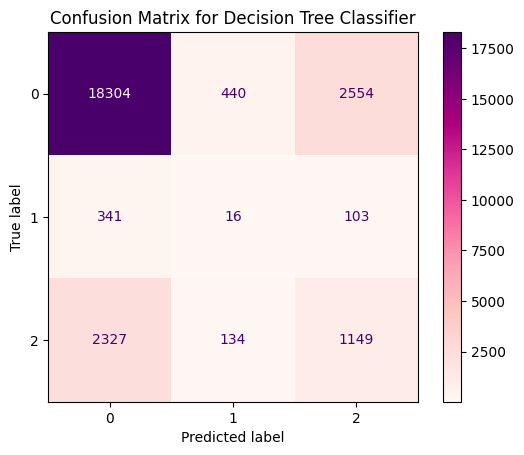

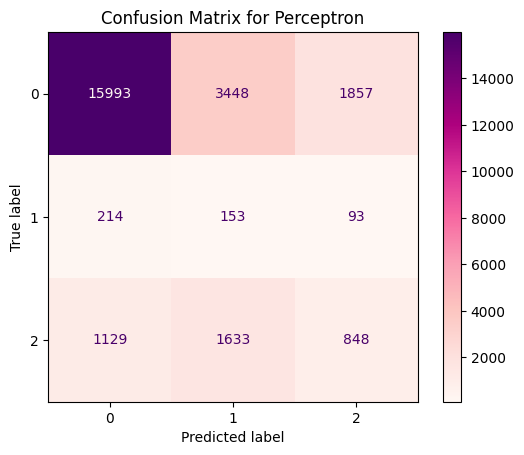

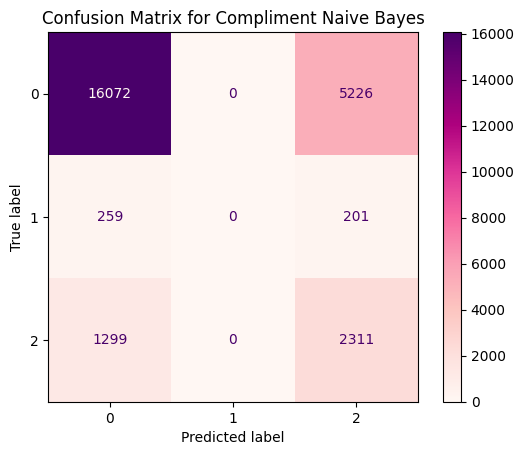

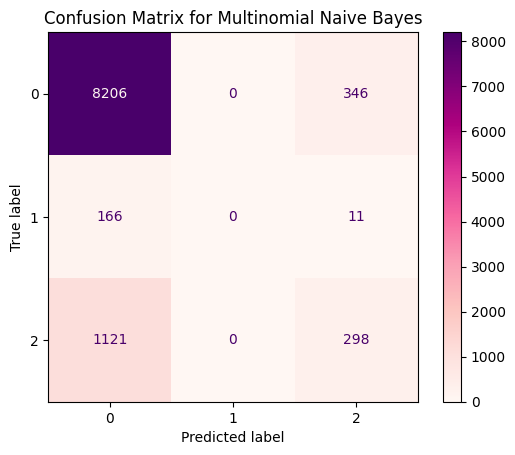

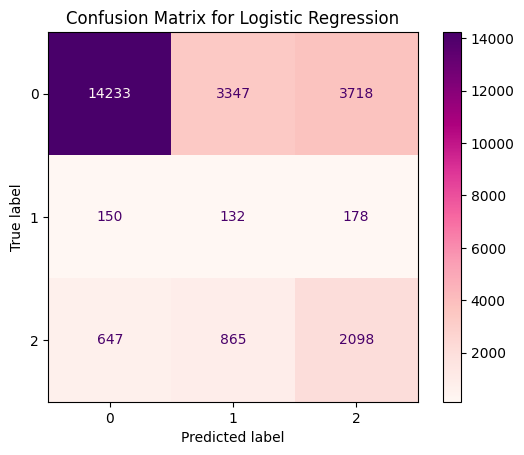

Cannot calculate Confusion Matrix for Regression Problems -  Linear Regression


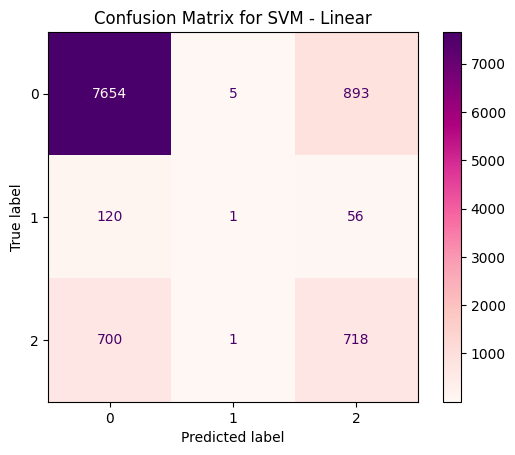

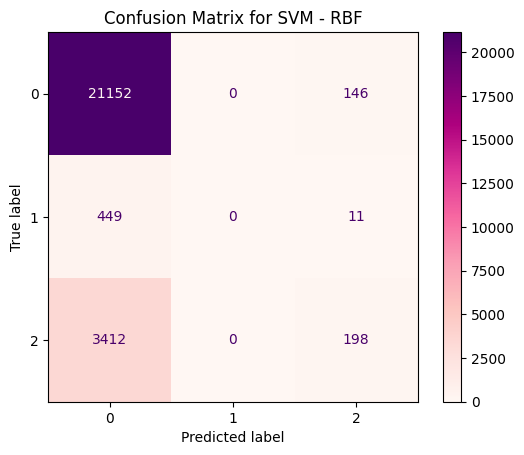

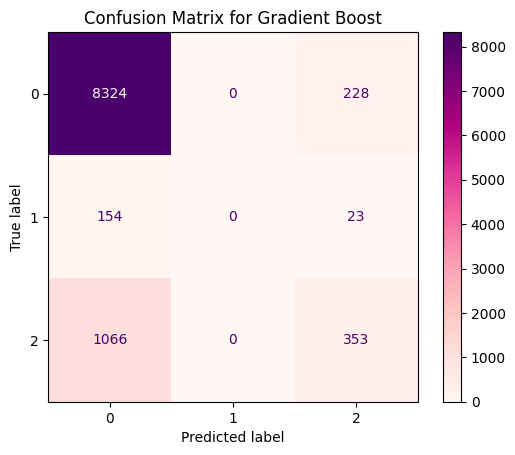

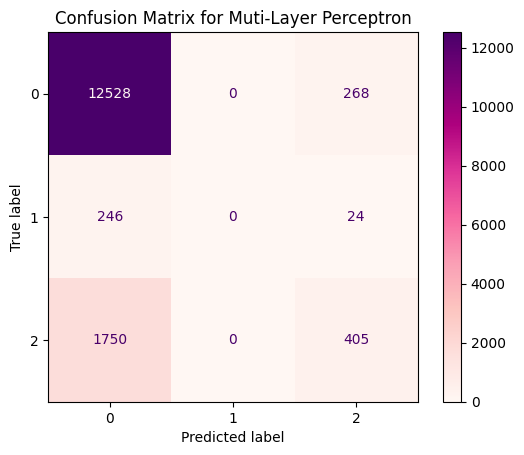

Cannot calculate Confusion Matrix for Regression Problems -  Regularilized Linear Regression
Cannot calculate Confusion Matrix for Regression Problems -  Lasso Linear Regression


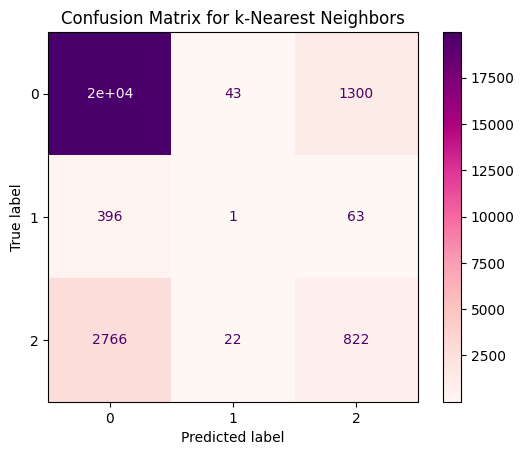

Cannot calculate Confusion Matrix for Regression Problems -  Linear Regression with Optimal Polynomial


In [171]:
# loop to generate confusion matrix
for b in range(len(best)):
  # skip models with Linear Regression in the title because cannot calculate confision matrix for continuious values
  if 'Linear Regression' not in best.iloc[b]['Model']:
    ConfusionMatrixDisplay.from_predictions(y_true=best.iloc[b]['true'], 
                                            y_pred=best.iloc[b]['pred'],
                                            cmap='RdPu')
    # set titles
    title=best.iloc[b]['Model']
    plt.title(f'Confusion Matrix for {title}')
    plt.show()
  else:
    # output confirmation that regression model was skipped
    print('Cannot calculate Confusion Matrix for Regression Problems - ', titles[b])

Selecting columns to display for the dataframe with all the best models. This dataframe holds one row for each model, indicating the best split, for each model, based on the best fold for that split, with the lowest MSE.

In [172]:
# drop columns with y_true and y_pred that were used to generate matrix
best = best.drop(['true', 'pred'], axis=1)

# adjust dataframe for better display
best.reset_index(inplace=True, drop=True) 
disp_best = best.style.set_caption(f'Best Split for Each Model')
display(disp_best)

,Model,Split,Error,Generalization
0,Decision Tree Classifier,"(0.5, 0.5)",0.755126,0.054634
1,Perceptron,"(0.5, 0.5)",0.553410,0.129813
2,Compliment Naive Bayes,"(0.5, 0.5)",0.979503,0.067485
3,Multinomial Naive Bayes,"(0.8, 0.2)",0.581917,0.013767
4,Logistic Regression,"(0.5, 0.5)",0.822231,0.045003
5,Linear Regression,"(0.5, 0.5)",0.377035,0.032603
6,SVM - Linear,"(0.8, 0.2)",0.638827,0.007014
7,SVM - RBF,"(0.5, 0.5)",0.566417,0.012738
8,Gradient Boost,"(0.8, 0.2)",0.527600,0.000107
9,Muti-Layer Perceptron,"(0.7, 0.3)",0.539566,0.008492


Display big_df with every metric for every model, for ever split. 

In [173]:
#output big_df with all metrics for every model, on every split
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(big_df)

,Model,Split,Accuracy,Precision,Recall,F1-Score,R2,Error
0,Decision Tree Classifier,"(0.5, 0.5)",0.762712,0.779191,0.762712,0.770714,-0.639927,0.810800
1,Decision Tree Classifier,"(0.5, 0.5)",0.758770,0.770480,0.758770,0.764441,-0.717260,0.849034
2,Decision Tree Classifier,"(0.5, 0.5)",0.757588,0.772060,0.757588,0.764666,-0.682422,0.833662
3,Decision Tree Classifier,"(0.5, 0.5)",0.777296,0.779709,0.777296,0.778497,-0.578215,0.782026
4,Decision Tree Classifier,"(0.5, 0.5)",0.763106,0.775657,0.763106,0.769133,-0.683217,0.834056
5,Decision Tree Classifier,"(0.5, 0.5)",0.763106,0.776811,0.763106,0.769602,-0.692763,0.838786
6,Decision Tree Classifier,"(0.5, 0.5)",0.767048,0.779843,0.767048,0.773147,-0.663331,0.824202
7,Decision Tree Classifier,"(0.5, 0.5)",0.779267,0.784601,0.779267,0.781887,-0.559919,0.772960
8,Decision Tree Classifier,"(0.5, 0.5)",0.763013,0.775484,0.763013,0.768988,-0.691032,0.837934
9,Decision Tree Classifier,"(0.5, 0.5)",0.781940,0.786532,0.781940,0.784221,-0.526829,0.755126
